# Codificador Automático

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from tensorflow import keras
from tqdm import tqdm

from utils.helper import (
    folder_to_sequence,
    df_to_sequence,
    Calibrator,
    MinMaxScaler_AE,
    train_test_split_ae,
)

from keras.models import Sequential
from keras.layers import (
    Dense,
    LSTM,
    Input,
    RepeatVector,
    TimeDistributed,
    Flatten,
    Dropout,
)

plt.style.use(["science", "ieee", "notebook"])

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (9, 4)

In [2]:
calibrator = Calibrator()
scaler = MinMaxScaler_AE()

In [5]:
window_size = 80
bigX = folder_to_sequence("VIDRO-B3", window_size=window_size)
print("data shape: ", bigX.shape)

100%|██████████| 17/17 [00:01<00:00, 12.81it/s]

data shape:  (11872, 80, 1)


In [6]:
Xtrain, Xval = train_test_split_ae(bigX)
scaler.fit(bigX)

Xtrain_N, Xval_N = scaler.transform(Xtrain), scaler.transform(Xval)

In [7]:
# teste 1
autoencoder = Sequential(
    [
        Input((None, 1)),  # Indica que as séries temporais são de apenas uma feature
        LSTM(window_size // 2, return_sequences=False),
        Dropout(0.25),
        RepeatVector(window_size),
        LSTM(window_size // 2, return_sequences=True),
        Dropout(0.25),
        TimeDistributed(Dense(1)),
        Flatten(),
    ]
)

In [8]:
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 80, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80, 40)         │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 80, 1)          │            41 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,721 (77.04 KB)

 Trainable params: 19,721 (77.04 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        save_best_only=True,
        monitor="val_loss",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=1e-5
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=80, verbose=1),
]

autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")

history = autoencoder.fit(
    Xtrain_N,
    Xtrain_N,
    validation_data=(Xval_N, Xval_N),
    epochs=500,
    batch_size=64,
    shuffle=True,
    callbacks=callbacks,
)

Epoch 1/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0397 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 2/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0068 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 3/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0041 - val_loss: 3.9789e-04 - learning_rate: 0.0010
Epoch 4/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0031 - val_loss: 8.2836e-04 - learning_rate: 0.0010
Epoch 5/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0027 - val_loss: 2.4230e-04 - learning_rate: 0.0010
Epoch 6/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0024 - val_loss: 1.7974e-04 - learning_rate: 0.0010
Epoch 7/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0022 - val_loss: 2.1953e-04 - learning_rate: 0.0010
Epoch 8/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0020 - val_loss: 1.6191e-04 - learning_rate: 0.0010
Epoch 9/500
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0017 - val_loss

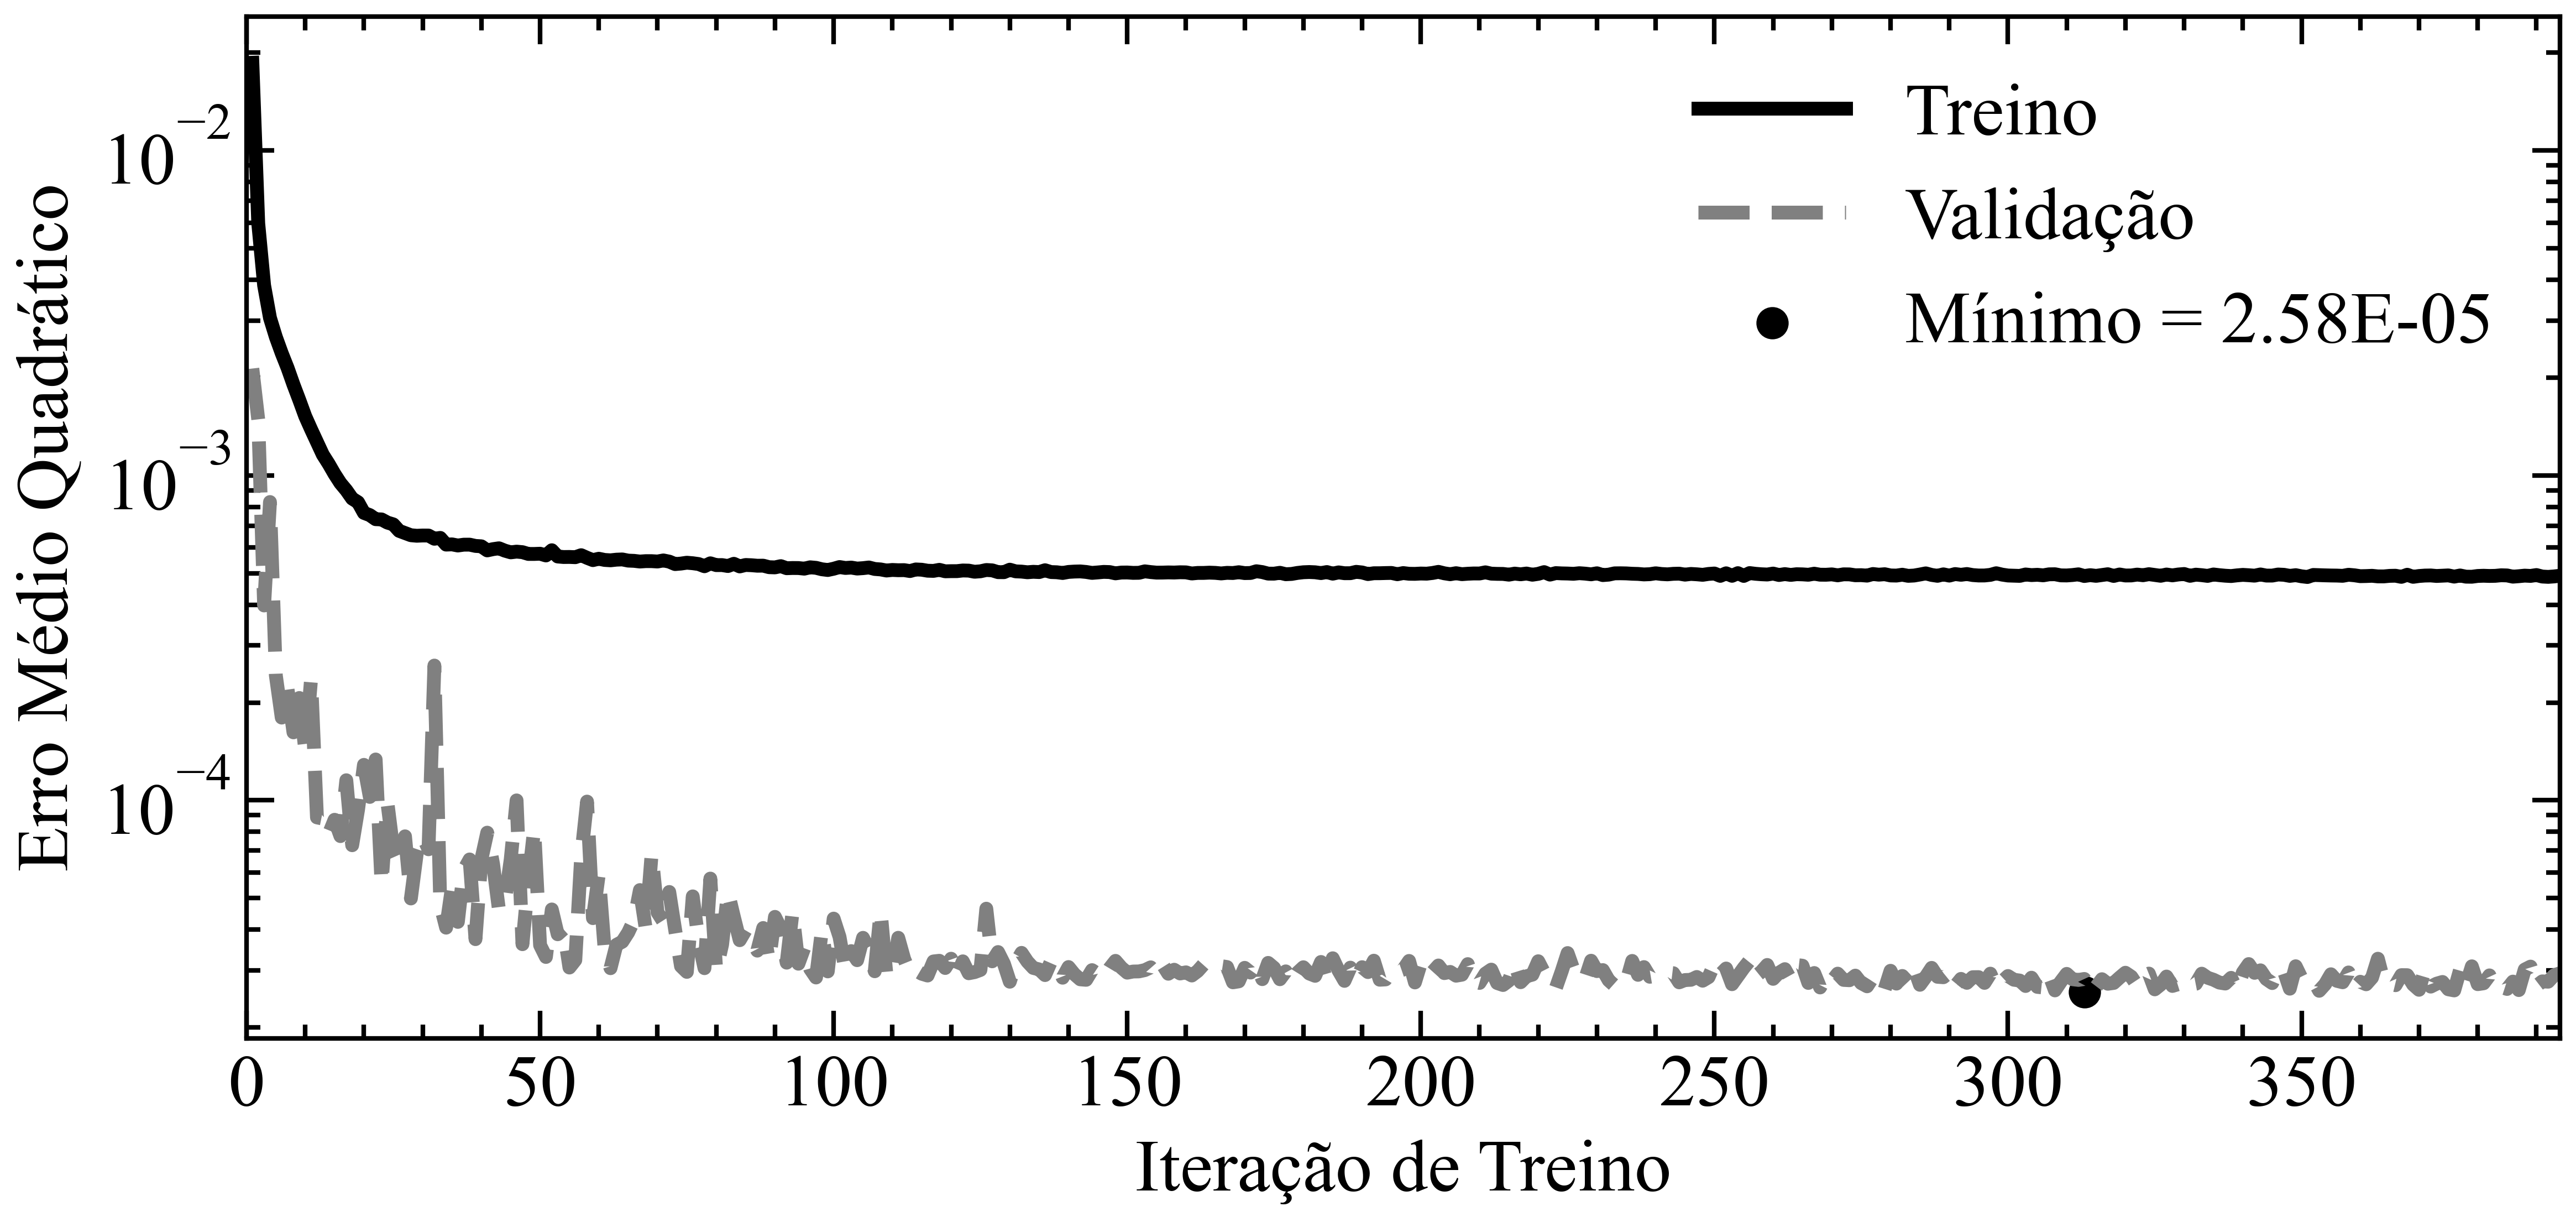

In [10]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = np.arange(1, len(loss) + 1)

plt.yscale("log", base=10)
plt.plot(epochs, loss, c="k", label="Treino", lw=3)
plt.plot(epochs, val_loss, c="grey", label="Validação", lw=3)
plt.scatter(
    np.argmin(val_loss), np.min(val_loss), label=f"Mínimo = {np.min(val_loss):.2E}"
)
plt.ylabel("Erro Médio Quadrático")
plt.xlabel("Iteração de Treino")
plt.xlim((0, len(loss)))
plt.legend()

plt.savefig("images/curva-de-aprendizdo.pdf", dpi=300, bbox_inches="tight")

In [11]:
predictions = autoencoder.predict(Xtrain_N)

279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


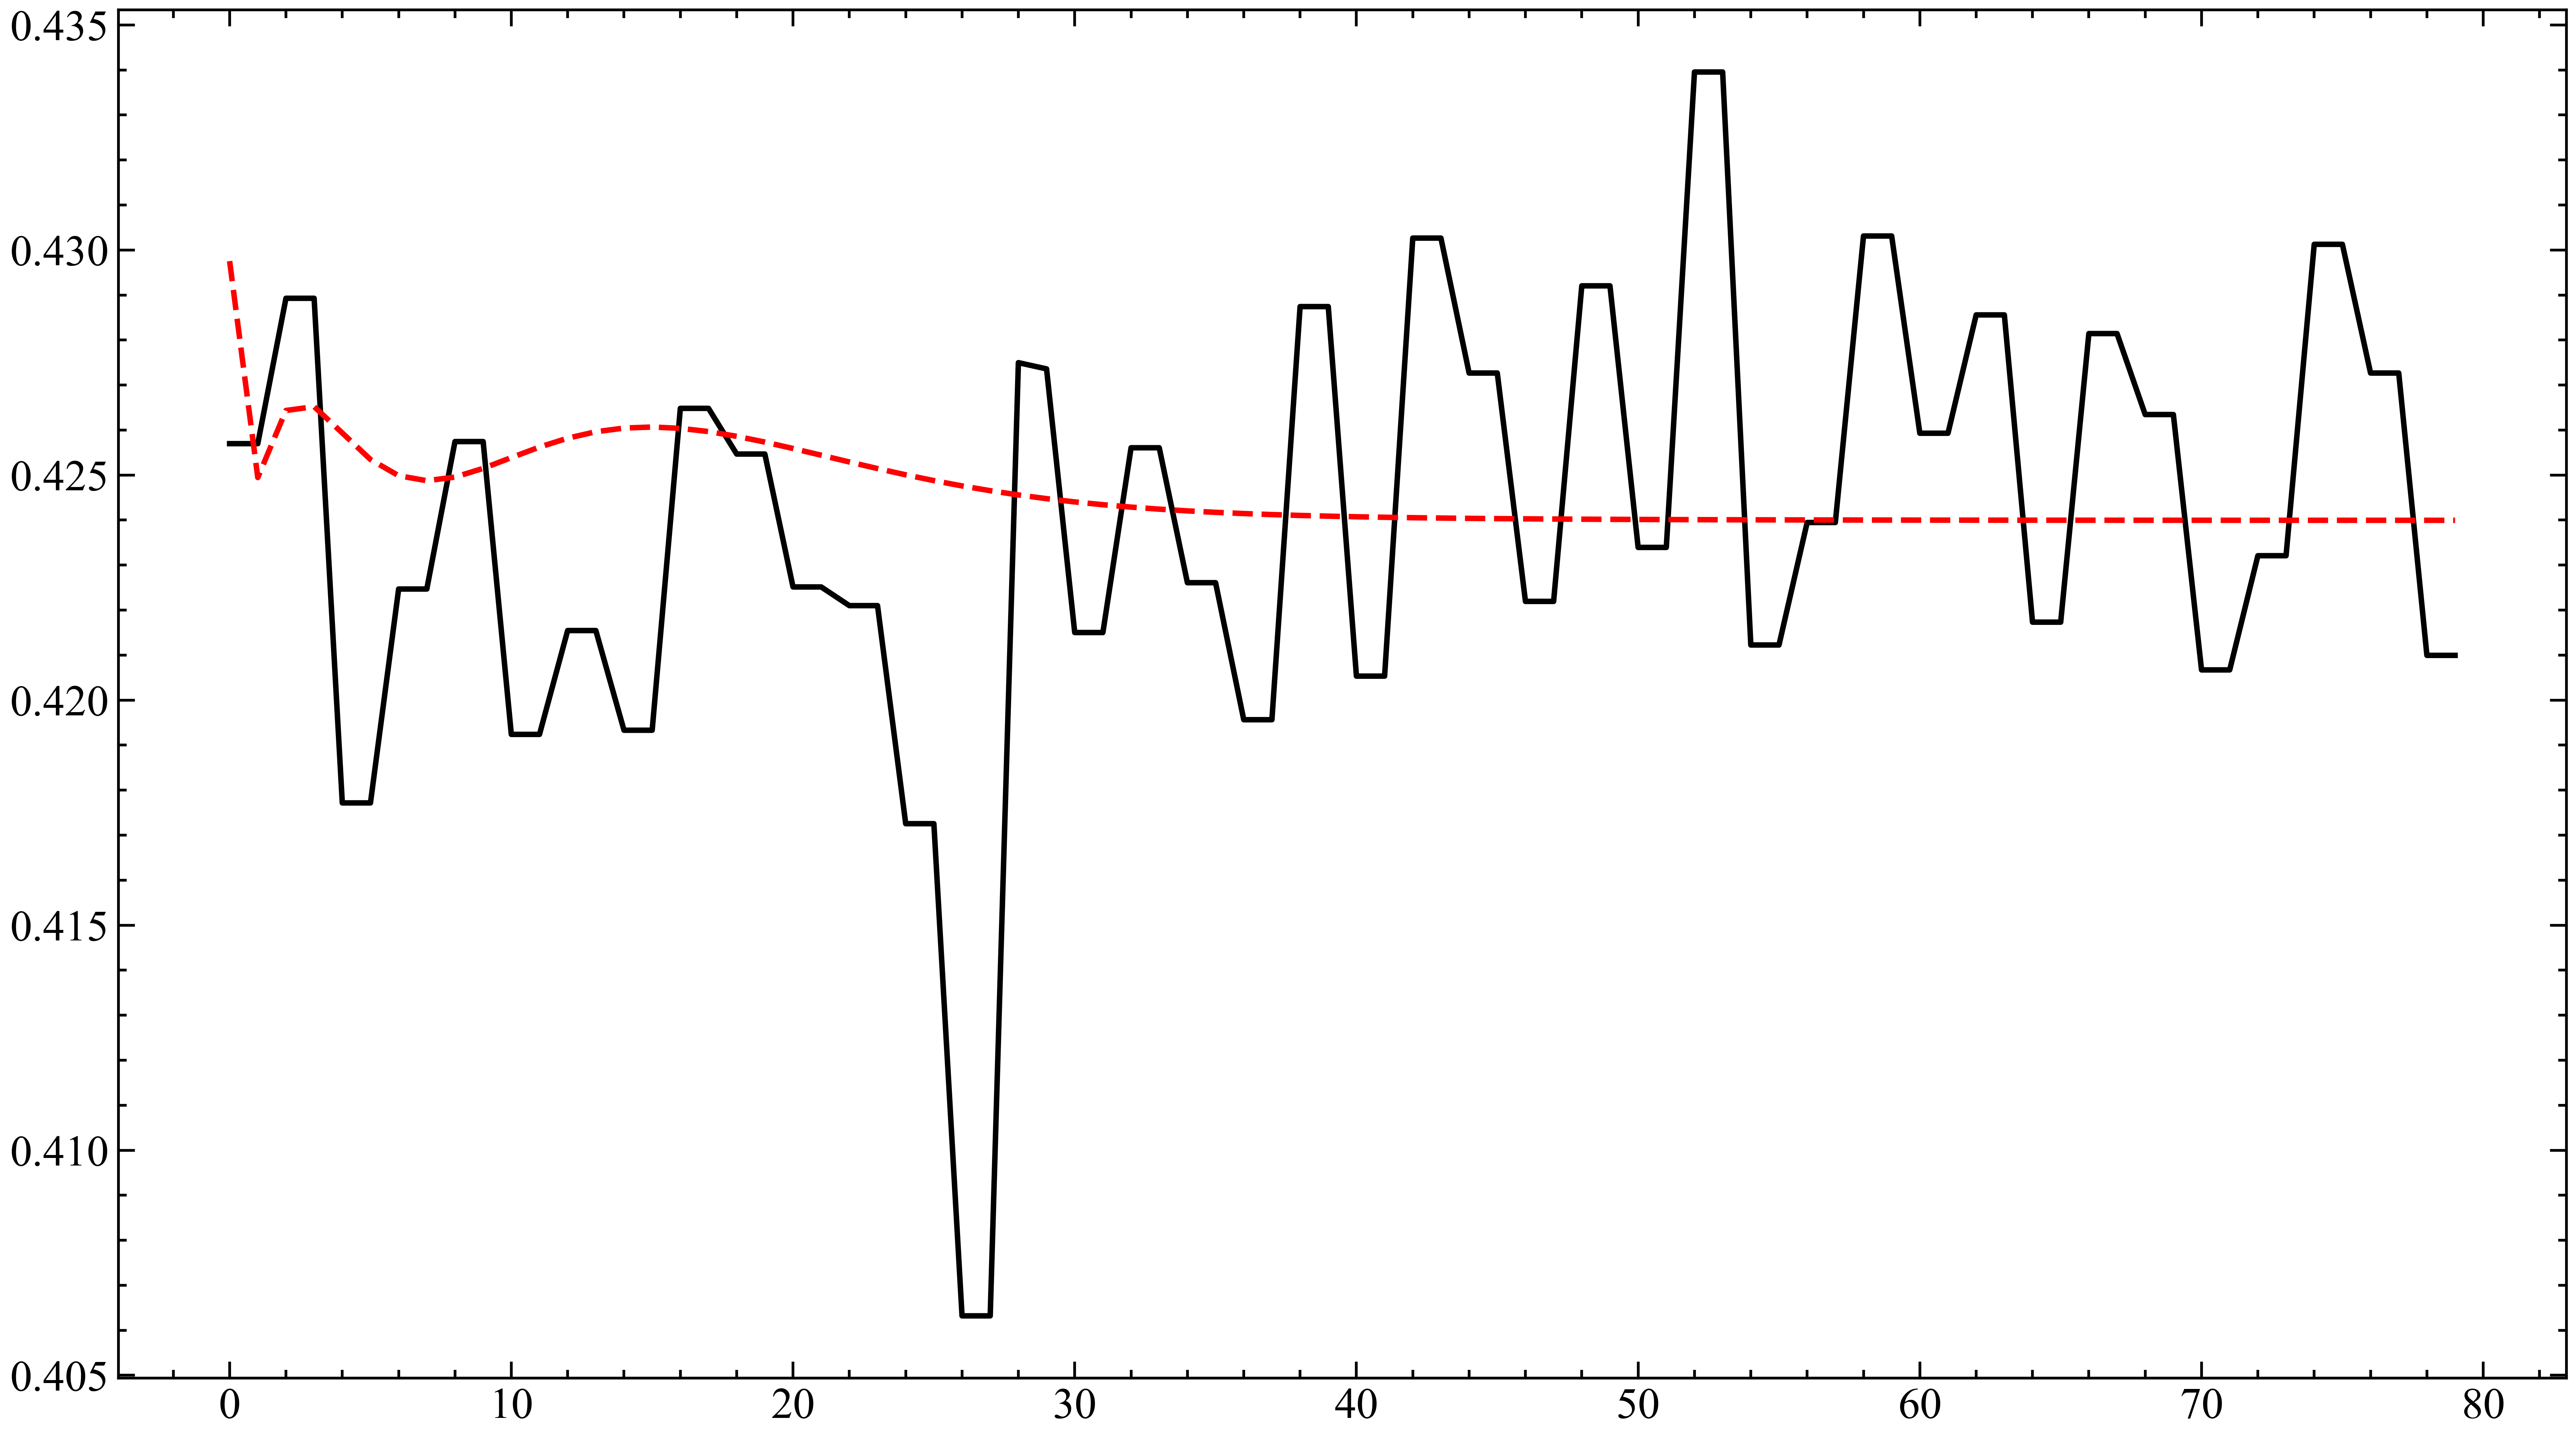

In [12]:
index: int = window_size * 4
plt.figure(figsize=(16, 9))
plt.plot(Xtrain_N[index])
plt.plot(predictions[index])